


# Análise exploratória de dados do Titanic

## Resumo
---
 
 [Introdução](#Introdução)

 [Conjunto de dados](#Conjunto-de-dados)
 
 [Ferramentas](#Ferramentas)

 [Questões-chave](#Questões-chave)

 Considerações

 [Referências](#Referências)

 # Introdução
 ...

# Ferramentas

Para análise foi utilizada a linguagem Python e suas bibliotecas: **pandas** para estrutura e manipulação de dados; **numpy** para operação com matrizes e vertores; **matplotlib** e **seaborn** para visualização de dados; **funções personalizadas** para manipulação dos dados; **formatação de tabela** personalizada para aprimorar a exibição dos dados.

In [2]:
# bibliotecas usadas para análise
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
% matplotlib inline
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn')

# bibliotecas complementares para análise
from data.data_modules import data_manipulation_functions as dm
from data.data_modules import data_plot_functions as pf
from data.data_modules import data_table_format as tab
from data.data_modules import data_styles_main as st

# Conjunto de dados

#### Fonte
A análise foi feita com os dados fornecidos pela Udacity a partir de uma amostra do site Kaggle.  
Para mais detalhes, esse é o link para a fonte dos dados https://www.kaggle.com/c/titanic/data

#### Preparação dos dados
Para deixar os dados mais legíveis e consistentes de modo a preservar a informação, os dados passaram por um processo de limpeza. Durante a execução, algumas colunas foram avaliadas com relação à qualidade e pertinência de serem utilizadas na análise. Assim, dentre as 12 colunas foram delimitadas as seguintes 10 colunas:

- **survived** (informa se sobreviveu)
- **ticket_class** (classe da passagem)
- **name** (nome)
- **gender** (sexo)
- **age** (idade)
- **siblings_or_spouses** (quantidade de irmãs(ãos) ou  cônjuges)
- **parents_or_children** (quantidade de pais ou filhas(os))
- **ticket_number** (número do bilhete)
- **fare** (tarifa paga) 
- **embarkation_city** (cidade de embarque)

Dentre as colunas, a que contém os dados referentes a idade possuia cerca de 80% dos dados completos. Para permitir cruzamentos entre outras variáveis, os cerca de 20% de dados foram preenchidos de modo randômico de modo a preservar a proporção de diferençãs de idade dos dados completos.

O passo a passo realizado pode ser verificado em [/data/data_wrangling.ipynb](./data/data_wrangling.ipynb)

In [3]:
# carregamento dos dados
data_titanic = pd.read_csv('./data/data_titanic_clean')

# exibição das 3 primeiras linhas do conjunto de dados
tab.format_table(data_titanic.head(10))

,name,age,gender,ticket_class,fare,ticket_number,embarkation_city,siblings_or_spouses,parents_or_children,survived
0,"Braund, Mr. Owen Harris",22,male,third,7.25,A/5 21171,Southampton,1,0,no
1,"Cumings, Mrs. John Bradley (Florence Briggs Thayer)",38,female,first,71.2833,PC 17599,Cherbourg,1,0,yes
2,"Heikkinen, Miss. Laina",26,female,third,7.925,STON/O2. 3101282,Southampton,0,0,yes
3,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",35,female,first,53.1,113803,Southampton,1,0,yes
4,"Allen, Mr. William Henry",35,male,third,8.05,373450,Southampton,0,0,no
5,"Moran, Mr. James",20.9,male,third,8.4583,330877,Queestown,0,0,no
6,"McCarthy, Mr. Timothy J",54,male,first,51.8625,17463,Southampton,0,0,no
7,"Palsson, Master. Gosta Leonard",2,male,third,21.075,349909,Southampton,3,1,no
8,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",27,female,third,11.1333,347742,Southampton,0,2,yes
9,"Nasser, Mrs. Nicholas (Adele Achem)",14,female,second,30.0708,237736,Cherbourg,1,0,yes


Além do conjunto de dados a partir da preparação, no decorrer da análise, novas combinações entre os dados foram realizadas conforme podem ser conferidas abaixo: 

In [4]:
# destino das pessoas
survivors = data_titanic.query('survived == "yes"')
victims = data_titanic.query('survived == "no"')

# viajantes sós vs acompanhados
alone = data_titanic.query('siblings_or_spouses == 0 and parents_or_children == 0')
group = data_titanic.query('siblings_or_spouses != 0 and parents_or_children != 0')
data_titanic['companion'] = pd.DataFrame({'companion':['alone']*len(alone.index)}, index=alone.index)
data_titanic['companion'].fillna('group', inplace=True)

# embarque
embarkation_cities = data_titanic.query('embarkation_city != "not_provided"')

# idade
data_titanic['maturity'] = data_titanic['age'].apply(lambda age: 'adult' if age < 18 else 'child')
adults = data_titanic.query('age > 18')
kids = data_titanic.query('age <= 18')

# cruzamentos entre conjunto de dados
companion_x_destiny = pd.crosstab(data_titanic['companion'], data_titanic['survived'], normalize='all')

#### Descrição da amostra
A amostra contém **891** dados que representam cerca de **20%** da quantidade total de **2224** referentes às pessoas presentes no navio. Por possuir apenas informações sobre a classe do tipo de passagem comprada, podemos inferir que essa **amostra é delimitada aos passageiros** do navio o que deixa de fora, assim, informações sobre a tripulação.

# Questões-chave
A investigação feita buscou focar em temas relacionados a idade, gênero e econômico a partir da amostra de dados do Titanic. Para chegar às questões da análise, primeiramente foram elaboradas algumas questões iniciais antes da limpeza dos dados e outras questões depois.
Assim, como resultado, as seguintes questões-chave foram elencadas:

#### Questões iniciais
- Pessoas com maior poder aquisitivo também foram as que mais sobreviveram à tragédia?
- É possível confirmar a crença de que mulheres e crianças são prioridade no salvamento dentre as pessoas passageiras?

#### Questões a partir da limpeza dos dados
- É possível afirmar que houve uma grande diferença dentre sobreviventes considerando seu local de embarque?
- Pessoas que viajaram sozinhas tiveram mais chances de sobreviver?

### Pessoas com maior poder aquisitivo também foram as que mais sobreviveram à tragédia?

Há duas variáveis no conjunto de dados que indicam poder aquisitivo: **ticket_class**(classe da passagem) e  **fare** (tarifa paga). Ambas ficam restritas ao contexto da viagem e outros bens como imóveis ou heranças não foram informados. Para efeito da análise, vamos considerar, principalmente, pessoas com alto poder aquisitivo àquelas da primeira classe e com alto valor de tarifa pago e pessoas com baixo poder aquisitivo o contrário.

A classe da passagem faz uma divisão em 3 tipos que, a princípio, sugere ser da mais cara para mais barata: primeira, segunda e terceira. Por si só já seria um critério que aponta, no geral, para o poder aquisitivo da pessoa. No entanto precisamos considerar que há casos de descontos da passagem (até mesmo não pagamento).

In [5]:
# quantidade de pessoas que não pagaram por classe de passagem
pd.crosstab(data_titanic.query('fare == 0')['fare'], data_titanic['ticket_class']).to_dict()

{'first': {0.0: 5}, 'second': {0.0: 6}, 'third': {0.0: 4}}

Dada a sugestão inicial, há de fato uma correspondência entre tipo de classe e valor pago na tarifa de fato nessa amostra?

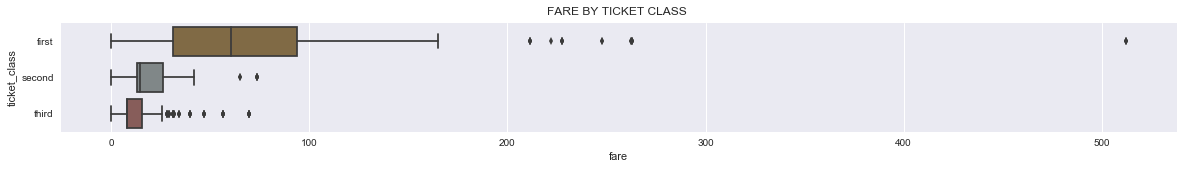

In [6]:
figure, ax = plt.subplots(1,1, figsize=(20,2))
# ----------------------------------------------------------------------------------------------------
fare_ticket_class = sns.boxplot(y='ticket_class', x='fare', data=data_titanic,\
            palette=st.palette_classes, order=['first', 'second', 'third'])
pf.set_title(fare_ticket_class, 'Fare by ticket class ')
# ----------------------------------------------------------------------------------------------------
figure.show()

Por meio da gráfico podemos confirmar que sim os valores da tarifa correspondem no geral, com exceção de alguns outliers (valores com anomalia em relação ao todo), ao tipo de classe de passagem: da primeira com tarifa maior até a terceira com tarifa menor.

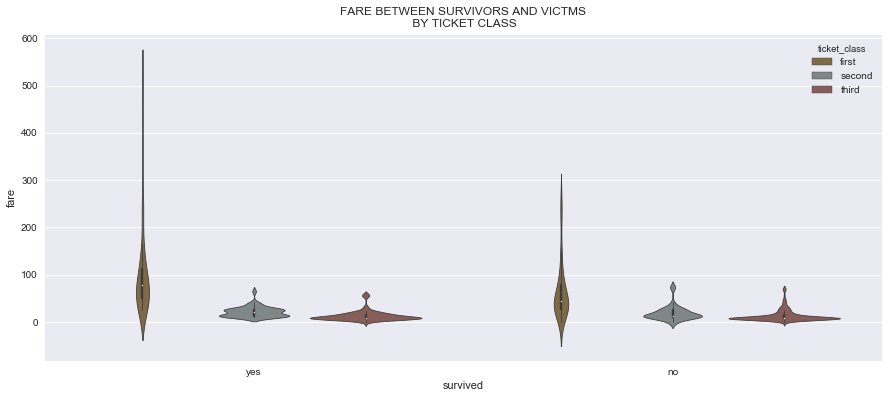

In [10]:
figure, ax = plt.subplots(1,1, sharex='col', sharey='row', figsize=(15,6))
# ----------------------------------------------------------------------------------------------------
fare_ticket_class_destiny = sns.violinplot(x='survived', y='fare', order=['yes','no'], data=data_titanic,\
                                   hue_order=['first','second','third'], hue='ticket_class',\
                                   palette=st.palette_classes, linewidth=0.8, )
pf.set_title(fare_ticket_class_destiny, 'Fare between survivors and victms\n by ticket class')
# ----------------------------------------------------------------------------------------------------
figure.show()

A tarifa paga do conjunto de dados não deixa claro sobre o que foi pago: passagem? taxa de embarque? serviços extras?
Vamos levar em conta que 

Outro ponto importante é que cada ponto de embarque


Por meio da distribuição dos valores das passagens, podemos observar a concentração dos valores pagos com relação aos sobreviventes e vítimas.

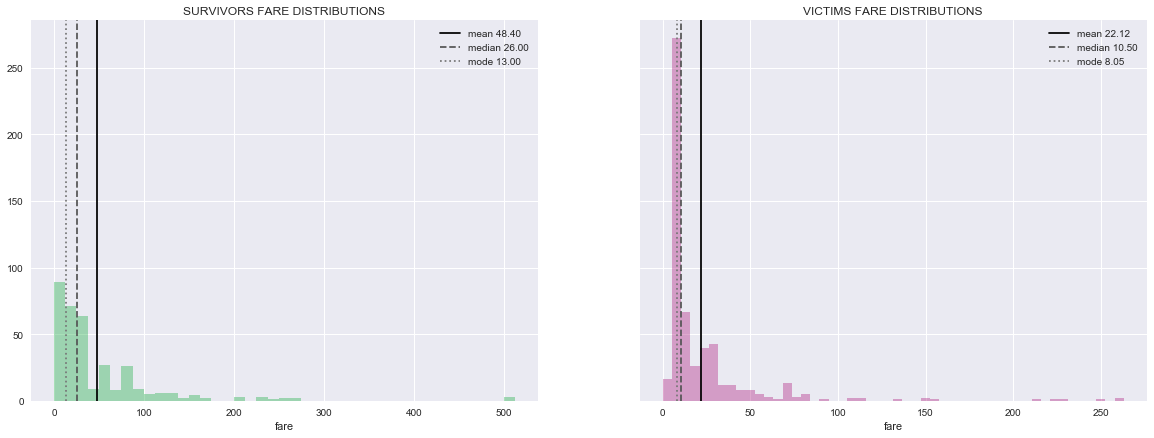

In [9]:
figure, ax = plt.subplots(1,2, sharex='col', sharey='row', figsize=(20,7))
# ----------------------------------------------------------------------------------------------------
fare_survivors = pf.plot_distribution_with_means(survivors['fare'], color=st.color_survivors,\
                                                 title='Survivors fare distributions', ax=ax[0])

fare_victims = pf.plot_distribution_with_means(victims['fare'], color=st.color_victims,\
                                               title='Victims fare distributions', ax=ax[1])
# ----------------------------------------------------------------------------------------------------
figure.show()

Comparando concentração de valores pagos podemos observar que a maior parte das vítimas foram aqueles com

Dado que isso aquilo aquilo outro

In [ ]:
embarkation_cities.query('embarkation_city == "Cherbourg" and ticket_class == "first"')['fare'].mode()

In [ ]:
# Data
r = [0,1,2,3,4]
raw_data = {'greenBars': [20, 1.5, 7, 10, 5], 'orangeBars': [5, 15, 5, 10, 15],'blueBars': [2, 15, 18, 5, 10]}
df = pd.DataFrame(raw_data)
 
# From raw value to percentage
totals = [i+j+k for i,j,k in zip(df['greenBars'], df['orangeBars'], df['blueBars'])]
greenBars = [i / j * 100 for i,j in zip(df['greenBars'], totals)]
orangeBars = [i / j * 100 for i,j in zip(df['orangeBars'], totals)]
blueBars = [i / j * 100 for i,j in zip(df['blueBars'], totals)]
 
# plot
barWidth = 0.85
names = ('A','B','C','D','E')
# Create green Bars
plt.bar(r, greenBars, color='#b5ffb9', edgecolor='white', width=barWidth)
# Create orange Bars
plt.bar(r, orangeBars, bottom=greenBars, color='#f9bc86', edgecolor='white', width=barWidth)
# Create blue Bars
plt.bar(r, blueBars, bottom=[i+j for i,j in zip(greenBars, orangeBars)], color='#a3acff', edgecolor='white', width=barWidth)
 
# Custom x axis
plt.xticks(r, names)
plt.xlabel("group")
 
# Show graphic
plt.show()


In [11]:
pd.crosstab(index=embarkation_cities['embarkation_city'], columns=embarkation_cities['ticket_class'],\
            values=embarkation_cities['fare'], aggfunc='sum', margins=True, )

ticket_class,first,second,third,All
embarkation_city,,,,
Cherbourg,8901.0750,431.0917,740.1295,10072.2962
Queestown,180.0000,37.0500,805.2043,1022.2543
Southampton,8936.3375,3333.7000,5169.3613,17439.3988
All,18017.4125,3801.8417,6714.6951,28533.9493


In [ ]:
pd.crosstab(index=embarkation_cities['embarkation_city'], columns=embarkation_cities['ticket_class'],\
            values=embarkation_cities['fare'], aggfunc='sum', normalize='all', margins=True)

In [ ]:
pd.crosstab(embarkation_cities['embarkation_city'], embarkation_cities['ticket_class'],\
            values=embarkation_cities['fare'], aggfunc='sum') 

### É possível confirmar a crença de que mulheres e crianças são prioridade no salvamento dentre as pessoas passageiras?

In [ ]:
sns.FacetGrid(adults, col='survived', hue='gender',\
              palette=st.palette_gender, height=3, aspect=2).map(sns.distplot, 'age', kde=False)
sns.FacetGrid(adults, col='survived', hue='maturity',\
              palette=st.palette_maturity, height=3, aspect=2).map(sns.distplot, 'age', kde=False)
# sns.catplot(x='survived', hue='maturity', data=data_titanic, kind='bar')

In [ ]:
pd.crosstab(index=data_titanic['gender'], columns=data_titanic['maturity'], margins=True, normalize='all')

### É possível afirmar que houve uma grande diferença dentre sobreviventes considerando seu local de embarque?

In [ ]:
pd.crosstab(data_titanic.query('embarkation_city != "not_provided"')['embarkation_city'], data_titanic['survived'], margins=True, normalize='index')

In [ ]:
# pf.set_plot_by(1,1, figsize=(20,2))
figure, ax = plt.subplots(1,2, sharex='col', sharey='row', figsize=(15,2.5))

ps_yes = pd.crosstab(data_titanic.query('embarkation_city != "not_provided"')['embarkation_city'],\
                 data_titanic.query('survived == "yes"')['survived'], normalize='all')
sns.heatmap(ps_yes, annot=True, fmt='#%', cmap=sns.light_palette(st.color_survivors), ax=ax[0], vmin=0, vmax=1)

ps_no = pd.crosstab(data_titanic.query('embarkation_city != "not_provided"')['embarkation_city'],\
                 data_titanic.query('survived == "no"')['survived'], normalize='all')
sns.heatmap(ps_no, annot=True, fmt='#%', cmap=sns.light_palette(st.color_victims), ax=ax[1], vmin=0, vmax=1)

figure.show()

>age >fare
>media considerando cada local de embarque tem valor diferente

### Pessoas que viajaram sozinhas tiveram mais chances de sobreviver?

In [ ]:
companion_plot = sns.catplot(y='survived', hue='companion', kind='count', data=data_titanic, order=['yes','no'],\
                             palette=st.palette_companion, height=2, aspect=6)

In [ ]:
sns.heatmap(companion_x_destiny, annot=True, fmt='#%', cmap='BuPu')

# Considerações

Embora focada em passageiros


**Critérios**:
- "Faça testes e sugira perguntas que promovam olhar para relacionamentos entre múltiplas variáveis"
- "Você deve analisar pelo menos uma variável dependente e três variáveis ​​independentes em sua investigação"
- "Uma definição de qual pergunta você fez"
- "Uma nota especificando qual foi o conjunto de dados usado"
- "Uma descrição do que você fez para investigar a pergunta"
Um PDF ou HTML contendo sua análise. Este arquivo deve conter:


Descrição de qualquer limpeza de dados feita  
Um resumo das estatísticas e gráficos comunicando seu resultado final  
O código usado para criar suas análises. Se você usou um notebook iPython, pode enviar seu .ipynb. Caso não o tenha feito, encaminhe os arquivos .py.



Para obter maior compreensão dos dados, segue uma descrição... ?? 

### Referências

##### Fonte
- [Kaggle - Titanic](https://www.kaggle.com/c/titanic/data)

##### Conteúdos sobre Titanic:
- [Em naufrágios, crianças e mulheres têm mesmo prioridade?](https://super.abril.com.br/mundo-estranho/em-naufragios-criancas-e-mulheres-tem-mesmo-prioridade/)
- [Em naufrágios e outros desastres, mulheres e crianças só conseguem sair por último](http://revistagalileu.globo.com/Revista/Common/0,,EMI302308-17770,00-EM+NAUFRAGIOS+E+OUTROS+DESASTRES+MULHERES+E+CRIANCAS+SO+CONSEGUEM+SAIR+POR+.html)
- [Nerdologia - Titanic](https://www.youtube.com/watch?v=GlEV_2qbvx8)


##### Análises de dados
- [Lautert, Larissa. Análise exploratória da fila - hacking-health-sc-2017](https://github.com/llautert/hacking-health-sc-2017/blob/master/An%C3%A1lise%20explorat%C3%B3ria%20da%20fila.ipynb)
- [Reis, Filipe - T2 - Análise Exploratória de Dados - Filipe Reis - RA091202](https://github.com/fireis/ia369w_exp_data_ana/blob/master/T2%20-%20Saude%20-%20Filipe%20Reis%20-%20RA091202.ipynb)
- [Siqueira, Fernando - Análise de notas de alunos](https://github.com/fernandolkf/dotdigitalgroup/blob/master/dotdigitalgroup.ipynb)


##### Técnicos
- [Handling missing data](https://www.oreilly.com/learning/handling-missing-data)
- [Mean Median Mode lines showing only in last graph in seaborn](https://stackoverflow.com/questions/51417483/mean-median-mode-lines-showing-only-in-last-graph-in-seaborn/51417635)

- [A collection of various notebook extensions for Jupyter](https://github.com/ipython-contrib/jupyter_contrib_nbextensions)
- [Python for Data Science and Machine Learning Bootcamp](https://www.udemy.com/python-for-data-science-and-machine-learning-bootcamp)
- [Percent stacked barplot](https://python-graph-gallery.com/13-percent-stacked-barplot/)
- [5 reasons you should use a violin graph](https://medium.com/@bioturing/5-reasons-you-should-use-a-violin-graph-31a9cdf2d0c6)

#### Complementares
- [The convention on the Rights of the child](https://www.unicef.org/crc/files/Guiding_Principles.pdf)